# Setup

## Imports

In [1]:
# Check if pykitti is installed, if not use pip to set it up
try:
    import pykitti
except ImportError:
    !pip install pykitti
    import pykitti

# Read the dataset sequence we just downloaded
basedir = '../kitti'
date = '2011_09_26'
drive = '0061'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# data = pykitti.raw(basedir, date, drive, frames=range(0, 50, 5))
try:
    data = pykitti.raw(basedir, date, drive)
except:
    !mkdir ../kitti
    !cd ../kitti && curl -O https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0035/2011_09_26_drive_0035_sync.zip
    !cd ../kitti && curl -O https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0061/2011_09_26_drive_0061_sync.zip
    !cd ../kitti && curl -O https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
    !cd ../kitti && unzip -o '*.zip'
    data = pykitti.raw(basedir, date, drive)

import cv2
from matplotlib import pyplot as plt
import numpy as np

from spatialmath import *
from spatialmath.base import *
from spatialmath.base import sym
from spatialgeometry import *

import time


## Functions and Classes

In [2]:
def motion_from_3D3D(X,Y):
    """Implements Arun's method for computing the motion from two sets of 3D points.    
    This returns a transform c2Tc1 such that Y = c2Tc1 * X, where X are the points before motion (first camera) 
    and Y are points after motion (second camera). The method is described in Arun et al. (1987)    
    """

    # determine the centroid
    mean_X = np.mean(X, axis=1)
    mean_Y = np.mean(Y, axis=1)

    # get the centered coordinates by subtracting the centroid
    XX = X - mean_X.reshape(-1,1)
    YY = Y - mean_Y.reshape(-1,1)

    # compute the 3x3vcovariance matrix
    H = np.dot(XX,YY.T)

    # compute the SVD of the covariance matrix
    U, S, Vt = np.linalg.svd(H)

    # compute the rotation matrix from U and Vt
    R = np.dot(Vt.T, U.T)
    
    # check if the R is a reflection and correct if needed
    if np.linalg.det(R)<0:  # det(R) is 1 for a rotation and -1 for a reflection
        Vt[2,:] *= -1
        R = np.dot(Vt.T, U.T)

    # compute the translation vector
    t = mean_Y - R @ mean_X
    
    # return the transform c2Tc1
    return SE3(t) * SE3(SO3(R))

def motion_from_2D2D(kp1, kp2, matches, camera_mat):
    """Estimate the motion between two images using the 2D-2D method."""
    
    # estimate the essential matrix
    E, mask = cv2.findEssentialMat(
        np.array([kp1[m.queryIdx].pt for m in matches]),
        np.array([kp2[m.trainIdx].pt for m in matches]),
        cameraMatrix=camera_mat, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    # recover the pose from the essential matrix
    points, R, t, mask = cv2.recoverPose(E,
        np.array([kp1[m.queryIdx].pt for m in matches]),
        np.array([kp2[m.trainIdx].pt for m in matches]))
    
    # we return a SE3 object describing the pose of the second camera in the frame of the first camera
    # we also return the mask of inliers
    return SE3(t) * SE3(SO3(R)), mask



In [3]:
def calc_essential_matrix(K, fundamental_mat):
    essential_mat = K.T @ fundamental_mat @ K

    # 1)we are calculating essential_mat E this way assuming that the coordinates are normalized.
    # 2) also, rank(fundamental_mat)=2 => rank(essential_mat) should be 2.
    # based on the points (1 and 2) above, we will put(enforce) the singular values of E as 1,1,0

    U, _, VT = np.linalg.svd(essential_mat)
    S = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 0]
    ])

    essential_mat = U @ S @ VT
    #essential_mat /= np.linalg.norm(essential_mat)
    return essential_mat

def calc_fundamental_matrix(self, point_list1, point_list2):
    point_list1, point_list2, trans_mat1, trans_mat2 = self.rescale_points(point_list1, point_list2)
    
    A = []
    for i in range(min(len(point_list1), len(point_list2))):
        A.append(np.kron(point_list2[i], point_list1[i]))
    
    U, S, VT = np.linalg.svd(A)
    fundamental_mat_vec = VT.T[:, -1]
    fundamental_mat = np.reshape(fundamental_mat_vec, (3,3))
    fund_mat_U, fund_mat_S, fund_mat_VT = np.linalg.svd(fundamental_mat)
    fund_mat_S = np.diag(fund_mat_S)
    
    # enforcing rank 2
    fund_mat_S[2,2] = 0
    #re-estimating the matrix with rank=2
    fundamental_mat = fund_mat_U @ fund_mat_S @ fund_mat_VT
    # rescaling the fundamental_mat
    fundamental_mat = trans_mat2.T @ fundamental_mat @ trans_mat1
    # normalizing fundamental_mat
    #fundamental_mat /= fundamental_mat[2,2]
    return fundamental_mat

def rescale_points(self, point_list1, point_list2):
    mean1 = np.mean(point_list1, axis=0)
    mean2 = np.mean(point_list2, axis=0)

    scale1 = self.get_scale(point_list1[:, :2], mean1[:2])
    scale2 = self.get_scale(point_list2[:, :2], mean2[:2])

    trans_mat1 = np.array([
        [scale1, 0, -scale1*mean1[0]],
        [0, scale1, -scale1*mean1[1]],
        [0, 0, 1]
    ])

    trans_mat2 = np.array([
        [scale2, 0, -scale2*mean2[0]],
        [0, scale2, -scale2*mean2[1]],
        [0, 0, 1]
    ])

    point_list1 = (trans_mat1 @ point_list1.T).T
    point_list2 = (trans_mat2 @ point_list2.T).T

    return point_list1, point_list2, trans_mat1, trans_mat2

def get_scale(self, point_list, mean):
    squares = (point_list-mean)**2
    sum_of_sq = np.sum(point_list, axis = 1)
    mean_ss = np.mean(sum_of_sq) # try np.mean(sum_of_sq)*len(sum_of_sq)
    return np.sqrt(2/mean_ss)
        
def soft2_motion(img_l1, img_r1, img_l2, img_r2, matches, kp1, kp2, camera_mat):
    # estimate the essential matrix
    E, mask = cv2.findEssentialMat(
        np.array([kp1[m.queryIdx].pt for m in matches]),
        np.array([kp2[m.trainIdx].pt for m in matches]),
        cameraMatrixsequence=camera_mat, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    inlier1 = kp1[mask]
    inlier2 = kp2[mask]
    
    E = calc_essential_matrix(camera_mat, calc_fundamental_matrix(inlier1, inlier2))
    

In [4]:
class FeatureDetector:
    def __init__(self, method: str):
        if method == 'sift':
            # detect features
            self.method = cv2.SIFT_create()
            self.detectAndCompute = self.method.detectAndCompute
            
        elif method == 'orb':
            # detect features
            self.method = cv2.ORB_create()
            self.detectAndCompute = self.method.detectAndCompute
        else:
            # not implemented error
            raise NotImplementedError(f'Feature detection method `{method}` not implemented.')
    
    def detectAndCompute(self, *args, **kwargs):
        raise NotImplementedError('Feature detector not initialised.')
        
class FeatureTracker:
    def __init__(self, method):
        if method == 'bf':
            # brute force
            self.method = cv2.BFMatcher()#(cv2.NORM_HAMMING, crossCheck=False)
            self.match = self.method.knnMatch
        else:
            # not implemented error
            raise NotImplementedError(f'Feature tracking method `{method}` not implemented.')
    
    def match(self, *args, **kwargs):
        raise NotImplementedError('Feature detector not initialised.')
        
class MotionEstimator:
    '''
    3D3D: 3D-3D correspondence \\
    2D2D: 2D-2D correspondence
    '''
    def __init__(self, correspondence: str):
        if correspondence == '3D3D':
            self.estimate_pose = motion_from_3D3D
        elif correspondence == '2D2D':
            self.estimate_pose = motion_from_2D2D
        else:
            # not implemented error
            raise NotImplementedError(f'Motion correspondence `{correspondence}` not implemented.')
    
    def estimate_pose(self, *args, **kwargs):
        raise NotImplementedError('Motion estimator not initialised.')

class LocalOptimizer:
    def __init__(self):
        pass

class Calibration:
    pass

class GroundTruth:
    pass

In [5]:
class VisualOdometry:
    def __init__(self, feat_detector: FeatureDetector, feat_tracker: FeatureTracker, motion_estimator: MotionEstimator, local_optimizer: LocalOptimizer):
        # Pipeline
        self.detector = feat_detector
        self.tracker = feat_tracker
        self.motion_estimator = motion_estimator
        self.local_optimizer = local_optimizer
        
        # Disparity
        self.stereo = cv2.StereoSGBM_create(numDisparities=16, blockSize=15)
        
        # Data
        self.img_l = None
        self.img_r = None
        self.gt = None
        
    def set_data(self, data: pykitti.raw):
        # Calibration info
        self.calib = Calibration()
        self.calib.K_l = data.calib.K_cam2
        self.calib.K_r = data.calib.K_cam3
        self.calib.P_l = data.calib.P_rect_20
        self.calib.P_r = data.calib.P_rect_30
        self.calib.b = data.calib.b_rgb
        self.calib.f = data.calib.P_rect_20[0][0]
        self.cx = self.calib.P_l[0, 2]
        self.cy = self.calib.P_l[1, 2]
        self.fx = self.calib.P_l[0, 0]
        self.fy = self.calib.P_l[1, 1]
        # Data
        self.img_l = []
        self.img_r = []
        for l, r in data.rgb:
            self.img_l.append(cv2.cvtColor(np.array(l), cv2.COLOR_RGB2GRAY))
            self.img_r.append(cv2.cvtColor(np.array(r), cv2.COLOR_RGB2GRAY))

        # Ground truth
        self.gt = GroundTruth()
        self.gt.traj = np.array([ [oxts.T_w_imu[0,3] for oxts in data.oxts], [oxts.T_w_imu[1,3] for oxts in data.oxts] ])
        
    def __check_data_set(self):
        if (self.calib == None 
                or self.img_l == None 
                or self.img_r == None
                or self.gt == None):
            raise AttributeError('Data has not been set.')
        return True
        
    def get_disparity(self, img1, img2):
        disparity = self.stereo.compute(img1, img2)  
        disparity = disparity.astype(np.float32) / 16.0
        # Avoid instability and division by zero
        disparity[disparity == 0.0] = 0.00001
        disparity[disparity == -1.0] = 0.00001
        return disparity
    
    def get_depth(self, disparity):
        depth = np.ones(disparity.shape)
        depth = (self.calib.f * self.calib.b) / disparity
        return depth
                
    def est_motion(self, img_l1, img_l2, img_r2):
        # extract features
        kp_l1, des_l1 = self.detect_features(img_l1)
        kp_l2, des_l2 = self.detect_features(img_l2)
        
        # match features
        matches = self.match_features(des_l2, des_l1, 2)
        # Apply ratio test
        good_matches = []
        for m,n in matches:
            if m.distance < 0.75*n.distance:
                good_matches.append([m])
                
        # Triangulate matched features 
        # get l-r disparity
        disparity2 = self.get_disparity(img_l2, img_r2)
        
        # calculate depths
        depth2 = self.get_depth(disparity2)
        
        # match features
        # matches = self.match_features(des_l2, des_l1, k=2)
        print(len(matches), len(good_matches))
        # Only considering keypoints that are matched for two sequential frames
        image1_points = np.float32(
            [kp_l1[m[0].trainIdx].pt for m in good_matches])
        image2_points = np.float32(
            [kp_l2[m[0].queryIdx].pt for m in good_matches])          
        
        # 3D calc current
        pts_3d_2, outliers = self.calc_3d(image2_points, depth2, max_depth=100)
        # Deleting the false depth points
        image1_points = np.delete(image1_points, outliers, 0)
        image2_points = np.delete(image2_points, outliers, 0)
        
        # # Apply Ransac Algorithm to remove outliers
        _, rvec, t, _ = cv2.solvePnPRansac(
            pts_3d_2, image1_points, self.calib.K_l, None)
        
        R = cv2.Rodrigues(rvec)[0]
        
        return (SE3(t) * SE3(SO3(R)), pts_3d_2)  
        
    def detect_features(self, img):
        return self.detector.detectAndCompute(img, None)
    
    def match_features(self, des1, des2, k=1):
        return self.tracker.match(des1, des2, k)
    
    def calc_3d(self, img_points, depth, max_depth=100):
        points_3D = np.zeros((0, 3))
        outliers = []

        # Extract depth information to build 3D positions
        for indices, (u, v) in enumerate(img_points):
            z = depth[int(v), int(u)]

            # We will not consider depth greater than max_depth
            if z > max_depth:
                outliers.append(indices)
                continue

            # Using z we can find the x,y points in 3D coordinate using the formula
            x = z*(u-self.cx)/self.fx
            y = z*(v-self.cy)/self.fy

            # Stacking all the 3D (x,y,z) points
            points_3D = np.vstack([points_3D, np.array([x, y, z])])
        return points_3D, outliers


# Visual Odometry Initialisation

In [6]:
orb_detector = FeatureDetector('orb')
sift_detector = FeatureDetector('sift')
bf_matcher = FeatureTracker('bf')
est_3d3d = MotionEstimator('3D3D')


vo = VisualOdometry(orb_detector, bf_matcher, est_3d3d, None)
vo.set_data(data)

# Visual Odometry

In [7]:
relative_poses = []

t_start = time.time()
dt_series = []

for i in range(len(vo.img_l[1:])):
    T, pts_3d = vo.est_motion(vo.img_l[i-1], vo.img_l[i], vo.img_r[i])
    
    relative_poses.append(T)

    if len(relative_poses) % 25 == 0:
        print("Processed %d images" % len(relative_poses))
        
    t_end = time.time()
    dt = t_end - t_start
    dt_series.append(dt)
    
    t_start = t_end
        

error: OpenCV(4.7.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:242: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'


In [ ]:
# Let's establish the position of the first camera in the world frame.
# We will assume that the first camera is looking along the x-axis of the world frame and is located at (0,0,0)
c1Rw = np.array([[0,-1,0],[0,0,-1],[1,0,0]])
c1Tw = SE3(SO3(c1Rw)) 
wTc1 = c1Tw.inv()       # this is the pose of camera 1 in the world frame, as seen by the world frame

# init ground truth
gt_pose = [SE3(pose) for pose in np.array([oxts.T_w_imu for oxts in data.oxts])]

# we will store the poses of the cameras in the world frame in this list
# initialise it with the pose of the first camera
trajectory = [wTc1]
rel_gt = []
for i, c1Tc2 in enumerate(relative_poses):     
    
    # recoverPose gives us the c2Tc1 transform, but we want the c1Tc2 transform. c1Tc2 gives us the pose of camera 2 in the frame of camera 1.
    # c1Tc2 = c2Tc1.inv() 

    # if the camera is moving backwards (-z direction) we need to invert the relative pose
    # this should have been caught by OpenCV's recoverPose function (?)
    if c1Tc2.t[2] < 0:
        c1Tc2.t[2] *= -1
    
    # this is the pose of the current camera in the world frame
    trajectory.append(trajectory[-1] * c1Tc2)
    # at the same time acquire relative ground truth
    if (i == 0):
        curr_rel = SE3(np.eye(4))
    else:
        curr_rel = gt_pose[i] / gt_pose[i-1]
    rel_gt.append(curr_rel)
    
    

(4, 131) (4, 131) (131,)
Mean ATE: 	8534.72 mm
Median ATE: 	9220.50 mm
Max ATE: 	14372.84 mm
RMSE: 		4783.28 mm
(130, 4, 4) (4, 131)
(4,) (4,) (130,)
Mean Relative Err: 	1030.37 mm
Median Relative Err: 	989.39 mm
Max Relative Err: 	2515.24 mm
RMSE: 	1061.67 mm
Mean Processing Time: 	0.047663492422837475


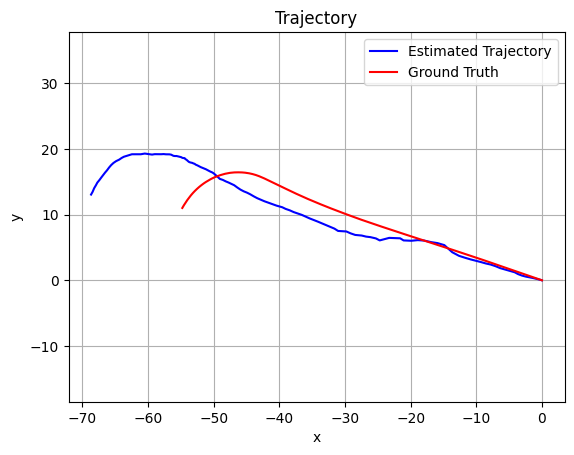

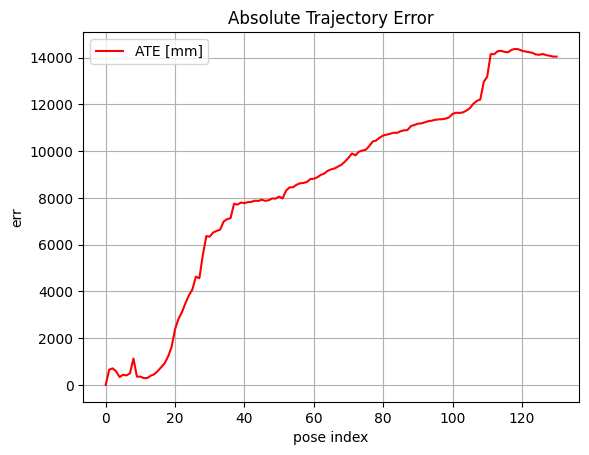

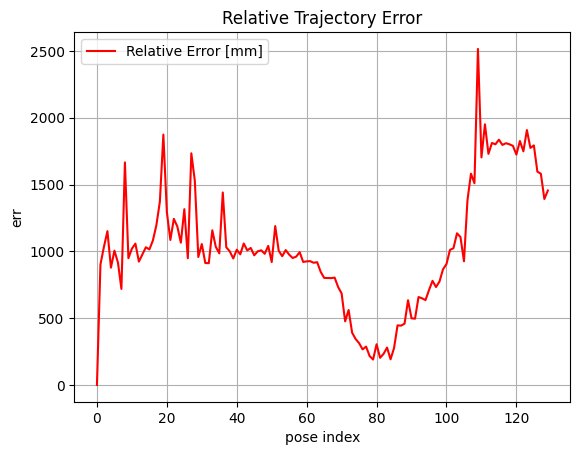

In [ ]:
# the world frame is not aligned with the ground truth frame (we'll call it g), so let's 
# get the first ground truth pose and use that to align world and ground truth frames
gTw = SE3(data.oxts[0].T_w_imu)

# our trajectory now is in world frame, so let's transform it to the ground truth frame
traj_gtframe = [gTw * T for T in trajectory]

# plot the estimated trajectory
traj = np.array([ [T.t[0] for T in traj_gtframe], [T.t[1] for T in traj_gtframe], [0 for _ in traj_gtframe], [1 for _ in traj_gtframe] ])
plt.plot(traj[0,:], traj[1,:],'b-', label='Estimated Trajectory')

# plot the ground truth into the same plot
gt = np.array([ [oxts.T_w_imu[0,3] for oxts in data.oxts], [oxts.T_w_imu[1,3] for oxts in data.oxts], np.zeros(traj.shape[1]), np.ones(traj.shape[1]) ])
plt.plot(gt[0,:], gt[1,:],'r-', label='Ground Truth')
#  give the plot an aspect ratio so that both axes are scaled equally
plt.axis('equal')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Trajectory')
plt.grid()
plt.legend()

# we can also plot more information, such as the error between the estimated and ground truth trajectories
# we also plot information about the number of matches and inliners, returned in the `masks` array we got in the cell above
error = np.linalg.norm(traj - gt, axis=0)
print(traj.shape, gt.shape, error.shape)
plt.figure()
plt.plot(error*1000,'r', label='ATE [mm]')
# plt.plot([len(m) for m in masks], label='Matched Features')
# plt.plot([np.sum(m)/255 for m in masks], '--', label='Inliers')
plt.xlabel('pose index'); plt.ylabel('err'); plt.title('Absolute Trajectory Error')
plt.legend()
plt.grid()

# print some error metrics
# ATE = Absolute Pose Error (but we only calculate it on the XY plane here)
# RMSE = Root Mean Squared Error
print(f'Mean ATE: \t{np.mean(error)*1000:.2f} mm')
print(f'Median ATE: \t{np.median(error)*1000:.2f} mm')
print(f'Max ATE: \t{np.max(error)*1000:.2f} mm')
print(f'RMSE: \t\t{np.sqrt(np.mean((traj - gt)**2))*1000:.2f} mm')

# Relative Error
print(np.array(relative_poses).shape, np.array(gt).shape)
rel_err = []
for i, pt in enumerate(gt[:,:-1].transpose()):
    traj_pt = np.array(relative_poses[i]) @ pt
    gt_pt = np.array(rel_gt[i]) @ pt
    rel_err.append(np.linalg.norm(traj_pt - gt_pt, axis=0))
# rel_err = 
rel_err = np.array(rel_err)
print(traj_pt.shape, gt_pt.shape, rel_err.shape)
plt.figure()
plt.plot(rel_err*1000,'r', label='Relative Error [mm]')
plt.xlabel('pose index'); plt.ylabel('err'); plt.title('Relative Trajectory Error')
plt.legend()
plt.grid()

print(f'Mean Relative Err: \t{np.mean(rel_err)*1000:.2f} mm')
print(f'Median Relative Err: \t{np.median(rel_err)*1000:.2f} mm')
print(f'Max Relative Err: \t{np.max(rel_err)*1000:.2f} mm')
print(f'RMSE: \t{(np.mean(rel_err)**2)*1000:.2f} mm')

print(f'Mean Processing Time: \t{np.mean(dt_series)}')

# Nielsen's Solution

In [ ]:
import NielsenVO.stereo_visual_odometry as nielsen
from tqdm import tqdm

vo = nielsen.VisualOdometry(data)

# play_trip(vo.images_l, vo.images_r)  # Comment out to not play the trip

gt_path = []
estimated_pose = []
estimated_path = []
for i, gt_pose in enumerate(tqdm(vo.gt_poses, unit="poses")):
    if i < 1:
        cur_pose = gt_pose
    else:
        transf = vo.get_pose(i)
        cur_pose = np.matmul(cur_pose, transf)
    gt_path.append((gt_pose[0, 3], gt_pose[2, 3]))
    estimated_pose.append(SE3(transf))
    estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))
        


100%|██████████| 131/131 [00:10<00:00, 12.24poses/s]


## Convert to Relative and what not

In [ ]:
# Let's establish the position of the first camera in the world frame.
# We will assume that the first camera is looking along the x-axis of the world frame and is located at (0,0,0)
c1Rw = np.array([[0,-1,0],[0,0,-1],[1,0,0]])
c1Tw = SE3(SO3(c1Rw)) 
wTc1 = c1Tw.inv()       # this is the pose of camera 1 in the world frame, as seen by the world frame

# init ground truth
gt_pose = [SE3(pose) for pose in np.array([oxts.T_w_imu for oxts in data.oxts])]

# we will store the poses of the cameras in the world frame in this list
# initialise it with the pose of the first camera
trajectory = [wTc1]
rel_gt = []
# relative_poses = []
for i, c1Tc2 in enumerate(estimated_pose):     
    # this is the pose of the current camera in the world frame
    trajectory.append(trajectory[-1] * c1Tc2)
    # trajectory.append(pose)
    # at the same time acquire relative ground truth
    if (i == 0):
        curr_gt_rel = SE3(np.eye(4))
        curr_est_rel = SE3(np.eye(4))
    else:
        curr_gt_rel = gt_pose[i] / gt_pose[i-1]
        # curr_est_rel = pose / relative_poses[i-1]
    rel_gt.append(curr_gt_rel)
    # relative_poses.append(curr_est_rel)
    

(4, 132) (4, 131)
Mean ATE: 	3704.73 mm
Median ATE: 	4245.39 mm
Max ATE: 	5925.57 mm
RMSE: 		2023.76 mm
Mean Relative Err: 	983.30 mm
Median Relative Err: 	963.93 mm
Max Relative Err: 	1889.94 mm
RMSE: 	966.87 mm
Mean Processing Time: 	0.047663492422837475


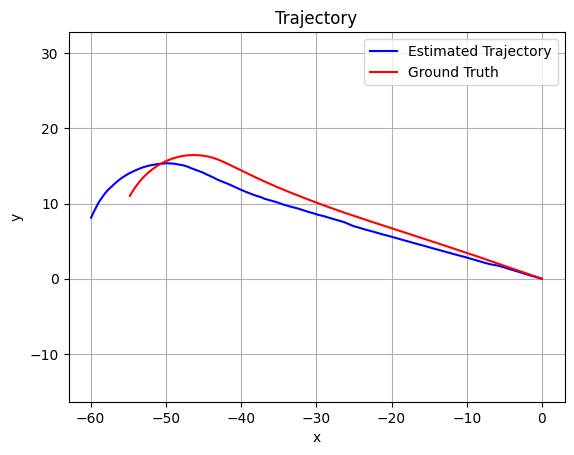

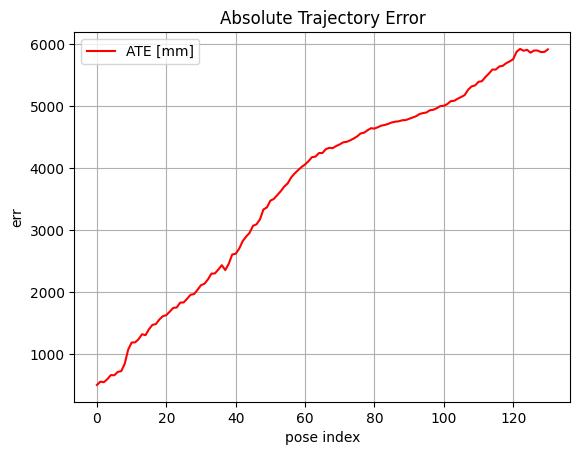

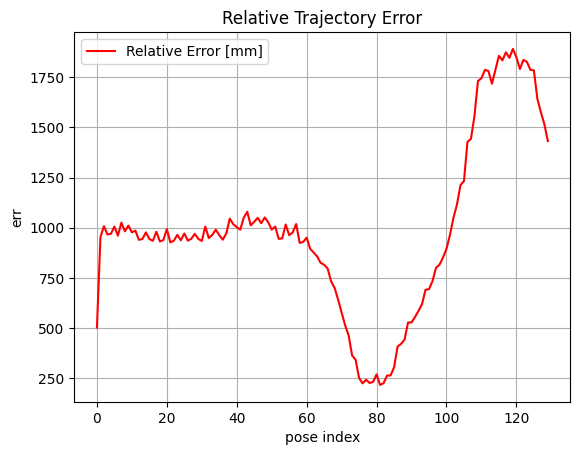

In [ ]:
# the world frame is not aligned with the ground truth frame (we'll call it g), so let's 
# get the first ground truth pose and use that to align world and ground truth frames
gTw = SE3(data.oxts[0].T_w_imu)

# our trajectory now is in world frame, so let's transform it to the ground truth frame
traj_gtframe = [gTw * SE3(T) for T in trajectory]

# plot the estimated trajectory
traj = np.array([ [T.t[0] for T in traj_gtframe], [T.t[1] for T in traj_gtframe], [0 for _ in traj_gtframe], [1 for _ in traj_gtframe] ])
plt.plot(traj[0,:], traj[1,:],'b-', label='Estimated Trajectory')

# plot the ground truth into the same plot
gt = np.array([ [oxts.T_w_imu[0,3] for oxts in data.oxts], [oxts.T_w_imu[1,3] for oxts in data.oxts], np.zeros(len(rel_gt)), np.ones(len(rel_gt)) ])
plt.plot(gt[0,:], gt[1,:],'r-', label='Ground Truth')
#  give the plot an aspect ratio so that both axes are scaled equally
plt.axis('equal')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Trajectory')
plt.grid()
plt.legend()

# we can also plot more information, such as the error between the estimated and ground truth trajectories
# we also plot information about the number of matches and inliners, returned in the `masks` array we got in the cell above
print(traj.shape, gt.shape)
error = np.linalg.norm(traj[:,1:] - gt, axis=0)
plt.figure()
plt.plot(error*1000,'r', label='ATE [mm]')
# plt.plot([len(m) for m in masks], label='Matched Features')
# plt.plot([np.sum(m)/255 for m in masks], '--', label='Inliers')
plt.xlabel('pose index'); plt.ylabel('err'); plt.title('Absolute Trajectory Error')
plt.legend()
plt.grid()

# print some error metrics
# ATE = Absolute Pose Error (but we only calculate it on the XY plane here)
# RMSE = Root Mean Squared Error
print(f'Mean ATE: \t{np.mean(error)*1000:.2f} mm')
print(f'Median ATE: \t{np.median(error)*1000:.2f} mm')
print(f'Max ATE: \t{np.max(error)*1000:.2f} mm')
print(f'RMSE: \t\t{np.sqrt(np.mean((traj[:,1:] - gt)**2))*1000:.2f} mm')

# Relative Error
rel_err = []
for i, pt in enumerate(gt[:,:-1].transpose()):
    traj_pt = np.array(estimated_pose[i]) @ pt
    gt_pt = np.array(rel_gt[i]) @ pt
    rel_err.append(np.linalg.norm(traj_pt - gt_pt, axis=0))
# rel_err = 
rel_err = np.array(rel_err)
plt.figure()
plt.plot(rel_err*1000,'r', label='Relative Error [mm]')
plt.xlabel('pose index'); plt.ylabel('err'); plt.title('Relative Trajectory Error')
plt.legend()
plt.grid()

print(f'Mean Relative Err: \t{np.mean(rel_err)*1000:.2f} mm')
print(f'Median Relative Err: \t{np.median(rel_err)*1000:.2f} mm')
print(f'Max Relative Err: \t{np.max(rel_err)*1000:.2f} mm')
print(f'RMSE: \t{(np.mean(rel_err)**2)*1000:.2f} mm')

print(f'Mean Processing Time: \t{np.mean(dt_series)}')